In [1]:
import os
import sys
import pandas as pd
import pylab as pl
import scipy as sp
from scipy import stats
import numpy as np
import statsmodels.formula.api as smf

pl.style.use('fivethirtyeight')
%pylab inline

DEVELOPE = True # cut data by a factor 1000 to allow faster processing
GEOPANDAS = True #False # use geopandas to get zips of rides
ALTERNATIVES = False # use pre-prepared files

Populating the interactive namespace from numpy and matplotlib


In [2]:
pl.rcParams['figure.figsize'] = [10.0, 6.0]

# 1.  Gathering Taxi data
### Download yellowcab data from 2009 and subsample it to reduce it to a manageable size


In [3]:
# check for PUIdata env var
PUIdata = os.getenv("PUIDATA")
"The path to the PUIdata directory is " + PUIdata

'The path to the PUIdata directory is /Users/fbb/Dropbox//UI/PUIdata'

##### downloading data


In [95]:
!curl -O https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2009-02.csv
    

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2303M  100 2303M    0     0  9250k      0  0:04:15  0:04:15 --:--:-- 9720k  0  0:04:29  0:00:01  0:04:28 8115k8M    0     0   9.9M      0  0:03:50  0:00:05  0:03:45 10.1M 726M    0     0  9185k      0  0:04:16  0:01:21  0:02:55 7782k0     0  9006k      0  0:04:21  0:01:45  0:02:36 8119k     0  8981k      0  0:04:22  0:01:47  0:02:35 7724k    0     0  8857k      0  0:04:26  0:01:58  0:02:28 7532k7M    0     0  8747k      0  0:04:29  0:02:33  0:01:56 7956k   0  0:04:25  0:02:51  0:01:34 10.2M  0     0  9012k      0  0:04:21  0:03:09  0:01:12 9391k2M    0     0  9105k      0  0:04:19  0:03:25  0:00:54 10.3M   0     0  9211k      0  0:04:16  0:03:54  0:00:22 9622kM    0     0  9215k      0  0:04:15  0:04:05  0:00:10 8867k


In [96]:
!mv yellow_tripdata_2009-02.csv $PUIDATA

In [97]:
# reading in data
if not ALTERNATIVES: 
    yc200902 = pd.read_csv(PUIdata + "/yellow_tripdata_2009-02.csv")
    yc200902.head()

In [98]:
if not ALTERNATIVES:
    if DEVELOPE: 
        yc200902_short = yc200902[::1000]
    else: 
        yc200902_short = yc200902
else: 
    yc200902_short = pd.read_csv(
        "http://cosmo.nyu.edu/~fb55/data/yc200902_tripdata_trimmed.csv", 
        index_col="Unnamed: 0")
yc200902_short.head()


,vendor_name,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,Rate_Code,store_and_forward,End_Lon,End_Lat,Payment_Type,Fare_Amt,surcharge,mta_tax,Tip_Amt,Tolls_Amt,Total_Amt
0,DDS,2009-02-03 08:25:00,2009-02-03 08:33:39,1,1.60,-73.992768,40.758325,NaN,NaN,-73.994710,40.739723,CASH,6.9,0.0,NaN,0.00,0.0,6.90
1000,VTS,2009-02-11 23:03:00,2009-02-11 23:29:00,1,11.95,-73.968478,40.760553,NaN,NaN,-73.972788,40.637433,CASH,28.5,0.5,NaN,0.00,0.0,29.00
2000,VTS,2009-02-28 07:22:00,2009-02-28 07:32:00,3,2.86,-73.986690,40.726995,NaN,NaN,-73.988673,40.755612,CASH,9.3,0.0,NaN,0.00,0.0,9.30
3000,VTS,2009-02-14 17:02:00,2009-02-14 17:22:00,4,4.60,-73.991188,40.723345,NaN,NaN,-73.946650,40.776628,Credit,14.9,0.0,NaN,2.00,0.0,16.90
4000,CMT,2009-02-08 11:54:51,2009-02-08 12:06:43,1,2.40,-73.980833,40.744672,NaN,NaN,-73.984400,40.718905,Credit,9.3,0.0,NaN,1.39,0.0,10.69


In [99]:
print ("the reducted dataset is {:d} observations by {:d} variables".\
       format(*yc200902_short.shape))

the reducted dataset is 13381 observations by 18 variables


# 2.  Reading in the income data for NYC
## Download income information from IRS for NYC and extract the income per person by zipcode 
##### downloading data

In [100]:
pd.read_excel(
        "http://www.nber.org/tax-stats/zipcode/2009/09zp33ny.xls").head()

,NEW YORK,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70
0,Individual Income Tax Returns: \nSelected Inco...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[Money amounts are in thousands of dollars],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ZIP\ncode [1],Size of adjusted gross income,Number of returns,Number of joint returns,Number with paid preparer's signature,Number of exemptions,Number of dependents,Adjusted gross income (AGI),Salaries and wages in AGI,NaN,...,Alternative minimum tax,NaN,Income tax [6],NaN,Total tax liability [7],NaN,Tax due at time of filing [8],NaN,Overpayments refunded [9],NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Number of returns,Amount,...,Number of returns,Amount,Number of returns,Amount,Number of returns,Amount,Number of returns,Amount,Number of returns,Amount
4,NaN,NaN,-1,-2,-3,-4,-5,-6,-7,-8,...,-60,-61,-62,-63,-64,-65,-66,-67,-68,-69


In [101]:
if not ALTERNATIVES:
    incomeByZip = pd.read_excel(
        "http://www.nber.org/tax-stats/zipcode/2009/09zp33ny.xls", 
                   skiprows=3).iloc[10::8, [0,1,2,3,6,7]]
    incomeByZip.to_csv("IncomeZipcode_2009.csv")
    incomeByZip.set_index(keys=["ZIP\ncode [1]"], inplace=True)
    incomeByZip.head()

In [102]:
if not ALTERNATIVES:
    incomeByZip.drop("Size of adjusted gross income", axis=1, inplace=True)

##### calculating pupolation in each zipcode

In [103]:
if not ALTERNATIVES:
    incomeByZip["POPULATION"] = (incomeByZip["Number of dependents"] + 
                    incomeByZip["Number of joint returns"] + 
                               incomeByZip["Number of returns"])
    incomeByZip["POPULATION"].head()

##### calculating income per person in each zipcode

In [104]:
if not ALTERNATIVES:
    incomeByZip["incomePC"] = (incomeByZip["Adjusted gross income (AGI)"] / 
                               incomeByZip["POPULATION"])

##### cleaning up

In [105]:
if not ALTERNATIVES:
    incomeByZip["ZIPCODE"] = incomeByZip.index.values
    incomeByZip.drop(["Number of returns", "Number of joint returns", 
                  "Number of dependents", "Adjusted gross income (AGI)"], 
                 axis=1, inplace=True)

In [106]:
if ALTERNATIVES:
    incomeByZip = pd.read_json("http://cosmo.nyu.edu/~fb55/data/zipincome.json")
    incomeByZip.set_index("ZIPCODE", inplace=True)

In [107]:
incomeByZip.index.values[0]

10001

In [108]:
incomeByZip.head()

,POPULATION,incomePC,ZIPCODE
ZIP code [1],,,
10001,17426.0,94.386319,10001
10002,77558.0,21.312824,10002
10003,38156.0,119.356720,10003
10004,3231.0,150.291551,10004
10005,7371.0,430.402252,10005


# 3. Feature engineering
## Feature engineering task: extract the trip duration from the data and the tip percentage


##### creating tip percentage

In [109]:
yc200902_short["tipPC"] = yc200902_short["Tip_Amt"] / yc200902_short["Fare_Amt"]

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [110]:
print ("the tip percentage is calculated as percentage of the Fare ")
yc200902_short["tipPC"].describe()

the tip percentage is calculated as percentage of the Fare 


count    13381.000000
mean         0.048661
std          0.148067
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          9.000000
Name: tipPC, dtype: float64

##### creting trip duration from drop off and pick up time

In [111]:
#python2 python3 may have differences here
try:
    yc200902_short["tripDuration"] = (pd.to_datetime(yc200902_short["Trip_Dropoff_DateTime"]) - 
         pd.to_datetime(yc200902_short["Trip_Pickup_DateTime"])).dt.seconds / 3600.
except TypeError:
    yc200902_short["tripDuration"] = np.array( [(((np.datetime64(t)) - 
                                                (np.datetime64(yc200902_short["Trip_Pickup_DateTime"].\
                                                               values[i]))).astype(float) / 3600)
                                                for i,t 
                                      in enumerate(yc200902_short["Trip_Dropoff_DateTime"])]) 
except:
    yc200902_short["tripDuration"] = ((pd.to_datetime(yc200902_short["Trip_Dropoff_DateTime"]) - 
         pd.to_datetime(yc200902_short["Trip_Pickup_DateTime"])) 
        * 1e9).astype("timedelta64", "s") / 3600.
    

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [112]:
print ("the trip duration is expressed in hours")
yc200902_short["tripDuration"].describe()

the trip duration is expressed in hours


count    13381.000000
mean         0.260709
std          1.315832
min          0.000000
25%          0.100000
50%          0.150833
75%          0.245000
max         23.983333
Name: tripDuration, dtype: float64

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1478k    0 1478k    0     0  1478k      0 --:--:-- --:--:-- --:--:-- 1637k
Archive:  YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
replace /Users/fbb/Dropbox//UI/PUIdata/ZIP_CODE_040114.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


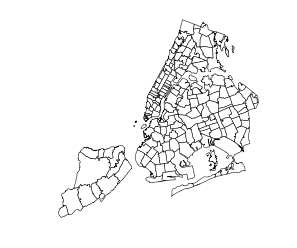

In [215]:
! curl -O https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
! unzip YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20\?filename\=ZIP_CODE_040114.zip -d $PUIDATA
zips = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
ax = zips.plot(color='white', edgecolor='black')
ax.axis('off');


Figure: boundaries of NYC zipcode. 

# 5. Finding the zipcode of each pick-up drop-off
## Find the zipcodes of taxi rides origin and destination 


In [113]:
if GEOPANDAS:
    import shapely
    from shapely import geometry
    import collections
    import geopandas as gp
    from fiona.crs import from_epsg
    
    !curl -O https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
    !unzip -d $PUIDATA application\%2Fzip
    zipsNYC = gp.GeoDataFrame.from_file(PUIdata + "/ZIP_CODE_040114.shp")
    zipsNYC.crs = from_epsg(2263) 
    
    
    ycgeodep = gp.GeoDataFrame(yc200902_short.copy())
    ycgeodes = gp.GeoDataFrame(yc200902_short.copy())

    # Create Point Geometry for based on lonlat column
    # combine lat and lon to one column
    ycgeodep['lonlat'] = list(zip(ycgeodep.Start_Lon, ycgeodep.Start_Lat))
    # Create Point Geometry for based on lonlat column
    ycgeodep['geometry'] = ycgeodep[['lonlat']].applymap(lambda x: 
                                                         shapely.geometry.Point(list(x)) )
    #shorty.head()
    ycgeodes['lonlat'] = list(zip(ycgeodes.End_Lon, ycgeodes.End_Lat))
    # Create Point Geometry for based on lonlat column
    ycgeodes['geometry'] = ycgeodes[['lonlat']].applymap(lambda x: 
                                                         shapely.geometry.Point(list(x)) )

    ycgeodes.crs = from_epsg(4326)
    ycgeodes.crs = from_epsg(4326)
    zipsNYC.to_crs(epsg=4326, inplace=True)
        
    goodcoords = ((ycgeodep['Start_Lat']>0) & (ycgeodep['End_Lat']>0) & \
                  (ycgeodep['Start_Lat']<80) & (ycgeodep['End_Lat']<80))

    ycgeodep = ycgeodep[goodcoords]
    departureZip = gp.sjoin(ycgeodep, zipsNYC, how="inner", op='intersects')[['Start_Lon', 
                                                                          'Start_Lat',
                                                                          'End_Lon',
                                                                          'lonlat', 
                                                                          'ZIPCODE']]
    
    ycgeodes = ycgeodes[goodcoords]
    destinationZip = gp.sjoin(ycgeodes, zipsNYC, how="inner", op='intersects')[['Start_Lon', 
                                                                          'Start_Lat',
                                                                          'End_Lon',
                                                                          'lonlat', 
                                                                          'ZIPCODE']]
    destinationZip.to_csv(PUIdata + "/destinationZIP.csv")
    departureZip.to_csv(PUIdata + "/departureZIP.csv")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   194    0   194    0     0    194      0 --:--:-- --:--:-- --:--:--   984
Archive:  application%2Fzip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of application%2Fzip or
        application%2Fzip.zip, and cannot find application%2Fzip.ZIP, period.


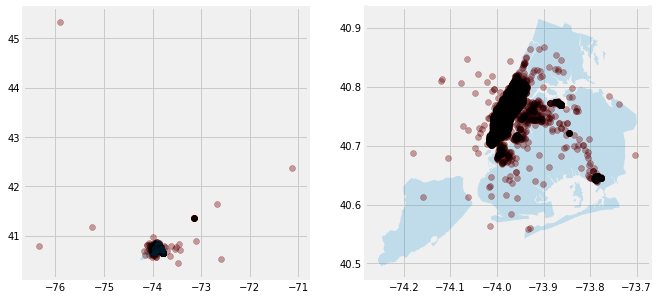

In [114]:
if GEOPANDAS:
    fig = pl.figure(figsize=(10,5))
    ax = fig.add_subplot(1,2,1)
    ycgeodep.plot(color='r', alpha=0.2, ax=ax)
    ycgeodep.plot(color='k', alpha=0.2, ax=ax)
    zipsNYC.plot(ax=ax, alpha=0.2)

    ax = fig.add_subplot(1,2,2)
    zipsNYC.plot(ax=ax, alpha=0.2)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ycgeodep.plot(color='r', alpha=0.2, ax=ax)
    ycgeodep.plot(color='k', alpha=0.2, ax=ax)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim);

#####  loading prepared files

In [115]:
if not GEOPANDAS:
    departureZip = pd.read_csv("http://cosmo.nyu.edu/~fb55/data/departureZIP.csv", 
                           index_col="Unnamed: 0")
    destinationZip = pd.read_csv("http://cosmo.nyu.edu/~fb55/data/destinationZIP.csv",
                             index_col="Unnamed: 0")

In [116]:
print ("the reducted dataset is {:d} observations, {:.2f} of the original".\
       format(departureZip.shape[0], 
              (destinationZip.shape[0] * 1.0 / yc200902_short.shape[0])))
print ("the reducted dataset is {:d} observations, {:.2f} of the original".\
       format(destinationZip.shape[0], 
              destinationZip.shape[0] * 1.0 / yc200902_short.shape[0]))

the reducted dataset is 13290 observations, 0.99 of the original
the reducted dataset is 13265 observations, 0.99 of the original


In [117]:
departureZip.head()

,Start_Lon,Start_Lat,End_Lon,lonlat,ZIPCODE
0,-73.992768,40.758325,-73.994710,"(-73.992768, 40.758325)",10036
48000,-73.985048,40.755035,-73.982035,"(-73.985048, 40.755035)",10036
98000,-73.989672,40.756602,-73.974902,"(-73.989672, 40.756602)",10036
138000,-73.988487,40.757317,-73.991500,"(-73.988487, 40.757317)",10036
162000,-73.984228,40.759523,-73.960294,"(-73.984228, 40.759523)",10036


In [118]:
destinationZip.head()

,Start_Lon,Start_Lat,End_Lon,lonlat,ZIPCODE
0,-73.992768,40.758325,-73.994710,"(-73.99471, 40.739723)",10011
7000,-73.999021,40.744549,-73.997600,"(-73.9976, 40.737661)",10011
32000,-73.982172,40.751662,-73.995922,"(-73.99592199999998, 40.733203)",10011
37000,-73.987318,40.733145,-74.000598,"(-74.00059799999998, 40.742468)",10011
60000,-73.986377,40.719460,-73.997386,"(-73.997386, 40.738333)",10011


##### merging the departure and destination files to extract departure and destination zipcodes only

In [119]:
zipcodes = departureZip[["ZIPCODE"]].merge(destinationZip[["ZIPCODE"]], 
                                           left_index=True, 
                                           right_index=True, how="inner").rename(
columns={"ZIPCODE_x": "ZIPCODEdep", "ZIPCODE_y":"ZIPCODEdes"})

In [120]:
zipcodes.head()


,ZIPCODEdep,ZIPCODEdes
0,10036,10011
1000,10022,11218
2000,10003,10018
3000,10002,10128
4000,10016,10002


In [121]:
print ("the merged departure-destination zipcode dataset is " + 
       "{:d} observations, {:.2f} of the original".\
       format(zipcodes.shape[0],zipcodes.shape[0] * 1.0 / yc200902_short.shape[0] ))

the merged departure-destination zipcode dataset is 13421 observations, 1.00 of the original


###### ISSUE: The size of the merged zipcode dataset is larger than the size of each dataset, this indicates that some of the datapoints appear multiple times in either dataset, generating multiple observations. While this is a concern, we know that the extraction of zipcodes from the coordinates of pickup and dropoff was done in geopandas, thought geometric shapes intersections. It is easily explained with coordinates at the edge of a zipcode geometric shape belonging to more than one shape, leading to repeated observations in the resulting dataframe, with multiple arrivals or multiple destinations. To confirm this let's check the indices: we should see repeated indices.


In [122]:
print ("number of unique indices in merged zipcode df {:d}".\
       format(zipcodes.index.unique().shape[0]))
print ("number of duplicate indices in merged zipcode df {:d}".\
       format(zipcodes.shape[0] - zipcodes.index.unique().shape[0]))
print ("percentage contamination by duplicate indices in merged zipcode df {:.2f}".\
       format(100 * (1.0 - (zipcodes.index.unique().shape[0] * 1.0 / 
                            zipcodes.shape[0]))))

number of unique indices in merged zipcode df 13069
number of duplicate indices in merged zipcode df 352
percentage contamination by duplicate indices in merged zipcode df 2.62


###### A contamination by <3% is acceptable and we do not expect it to affect our result, especially since we expect the duplicate entries to be associated with multiple **neighbouring** zipcodes, that are unlikely to have significantly different income. I choose to keep only the first entry for each index.

In [123]:
zipcodes = zipcodes.reset_index().drop_duplicates(subset='index', 
                                                  keep='last').set_index('index')
zipcodes.ZIPCODEdep = zipcodes.ZIPCODEdep.astype(int64)
zipcodes.ZIPCODEdes = zipcodes.ZIPCODEdes.astype(int64)

In [124]:
print ("number of unique indices in merged zipcode df {:d}".\
       format(zipcodes.index.unique().shape[0]))
zipcodes.head()

number of unique indices in merged zipcode df 13069


,ZIPCODEdep,ZIPCODEdes
index,,
0,10036,10011
1000,10022,11218
2000,10003,10018
3000,10002,10128
4000,10016,10002


# 6. Data aggregation 
## Join the datasets so that your data contains at least: trip duration, trip distance, fare amount, tip percentage, departure zipcode income, and destination zipcode income. 

##### merging zipcodes and income to obtain income at departure and destination for every ride with associated zipcodes

In [125]:
ridesIncome = zipcodes.merge(incomeByZip, left_on="ZIPCODEdep", right_index=True).\
    rename(columns={"incomePC":"incomeDep"}).merge(incomeByZip, left_on="ZIPCODEdes", 
                                           right_index=True).rename(
    columns={"incomePC":"incomeDes"})[["incomeDep", "incomeDes"]]
ridesIncome.head()

,incomeDep,incomeDes
index,,
0,120.643519,121.765217
192000,120.643519,121.765217
398000,120.643519,121.765217
769000,120.643519,121.765217
1708000,120.643519,121.765217


In [126]:
print ("number of unique indices in merged zipcode df {:d}, {:.2f} of the rides".\
       format(ridesIncome.shape[0], ridesIncome.shape[0] * 1.0 / zipcodes.shape[0] ) + 
       " have income at arrival and destination")


number of unique indices in merged zipcode df 11981, 0.92 of the rides have income at arrival and destination


##### Merging the rides information with the income information

In [127]:
yc200902_final = yc200902_short[["Trip_Distance", "Fare_Amt", 
                "tripDuration", "tipPC"]].merge(ridesIncome, right_index=True,
                                                left_index=True)
yc200902_final.head()

,Trip_Distance,Fare_Amt,tripDuration,tipPC,incomeDep,incomeDes
0,1.60,6.9,0.144167,0.000000,120.643519,121.765217
1000,11.95,28.5,0.433333,0.000000,252.197725,20.352433
2000,2.86,9.3,0.166667,0.000000,119.356720,238.665860
3000,4.60,14.9,0.333333,0.134228,21.312824,178.157744
4000,2.40,9.3,0.197778,0.149462,115.621026,21.312824


In [128]:
print ("number of observation inf the final dataset (before outliers rejection) " + 
       "{:d}, a fraction of {:.2f} of all registered rides".\
       format(yc200902_final.shape[0], 
              yc200902_final.shape[0] * 1.0 / yc200902_short.shape[0] ))


number of observation inf the final dataset (before outliers rejection) 11981, a fraction of 0.90 of all registered rides


# Analysis

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/GEOP/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['xlim', 'ylim']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
//anaconda/envs/GEOP/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


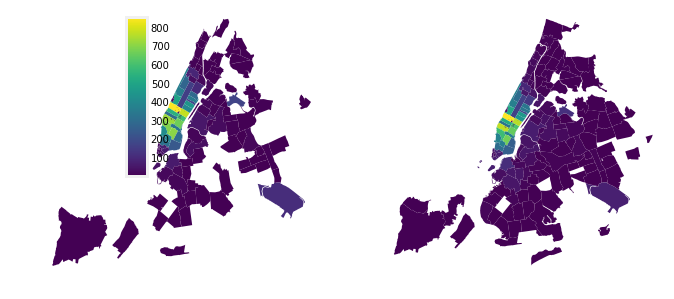

In [129]:
import pandas as pd
import choroplethNYC as cp
%pylab inline
departureZip = pd.read_csv("http://cosmo.nyu.edu/~fb55/data/departureZIP.csv", 
                           index_col="Unnamed: 0")
destinationZip = pd.read_csv("http://cosmo.nyu.edu/~fb55/data/destinationZIP.csv",
                             index_col="Unnamed: 0")

zipsNYC['ZIPCODE'] = zipsNYC['ZIPCODE'].astype(int)

fig = pl.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
cp.choroplethNYC(zipsNYC.merge(departureZip.groupby('ZIPCODE').count().reset_index()), column = "Start_Lon", ax=ax1)
ax2 = fig.add_subplot(122)
cp.choroplethNYC(zipsNYC.merge(destinationZip.groupby('ZIPCODE').count().reset_index()), column = "Start_Lon", ax=ax2);


# 6. Tip percentages
## Plot the distribution of tip percentages and *report its first and second moment*. Remove outliers, replot and see if the moments changed significantly. 

In [130]:
print ("characteristics of the tips percentage distribution")
yc200902_final.tipPC.describe()

characteristics of the tips percentage distribution


count    11981.000000
mean         0.048310
std          0.152607
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          9.000000
Name: tipPC, dtype: float64

In [131]:
print ("the first and second moments of the tip distribution are " + 
       "{:.2f} and {:.2} respectively".format(yc200902_final.tipPC.mean(), 
                                             yc200902_final.tipPC.std()))

the first and second moments of the tip distribution are 0.05 and 0.15 respectively


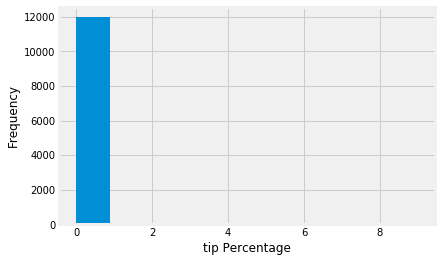

In [132]:
ax = yc200902_final.tipPC.plot(kind="hist")
ax.set_xlabel("tip Percentage");

###### Fig 1

Histogram of the distribution of tips as percentage of fare for all yellowcab rides in February 2009 with valid arrival and departure zipcodes within NYC (~90% of all registered rides). The distribution is dominated by very low percentage tips, and it stretches to 900%.

##### outlier rejection on tips

In [133]:
print ("fraction of 0 tips: {:.2f}".format((yc200902_final.tipPC == 0).sum() * 1.0 / 
       yc200902_final.shape[0]))
print ("fraction of tips > 1/2 of fare: {:.2f}".format((yc200902_final.tipPC > 0.5).sum() * 1.0 / 
       yc200902_final.shape[0]))
print ("number of tips > 1/2 of fare: {:.2f}".format((yc200902_final.tipPC > 0.5).sum()))

fraction of 0 tips: 0.77
fraction of tips > 1/2 of fare: 0.00
number of tips > 1/2 of fare: 38.00


although the percentiles, up to the 75% percentile are all 0 due to the overwhealming number of $0 tips, tips of 50% may reasonablly be considered outliers, and they are less than 1% of the original set

tips that are $0 are likely dominated by cash tips that are not recorded by the driver to not to pay taxes on it. We will remove them as well

In [134]:
# indices of valid tips
tipcut = (yc200902_final.tipPC>0) & (yc200902_final.tipPC<.50)

In [135]:
print ("distribution of non-zero tips less than 0.5xfare")
yc200902_final.tipPC[tipcut].describe()

distribution of non-zero tips less than 0.5xfare


count    2684.000000
mean        0.198399
std         0.077377
min         0.000592
25%         0.149351
50%         0.200000
75%         0.233766
max         0.491803
Name: tipPC, dtype: float64

In [136]:
print ("the first and second moments of the tip distribution are " + 
       "{:.2f} and {:.2} respectively".format(yc200902_final.tipPC[tipcut].mean(), 
                                             yc200902_final.tipPC[tipcut].std()))

the first and second moments of the tip distribution are 0.20 and 0.077 respectively


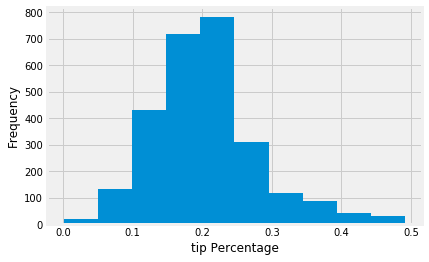

In [137]:
ax = yc200902_final.tipPC[tipcut].plot(kind="hist")
ax.set_xlabel("tip Percentage");

###### Fig 2

Histogram of the distribution of tips as percentage of fare for the subset of data from Figure 1 where the tip is non-zero and less than 50% of the fare. The distribution is now bellshaped, with mean near the standard 20% tip with a standard deviation of 8%

In [138]:
# create a new view of the DF with the chosen cuts on tips
yc200902_final_cut = yc200902_final[tipcut]

In [139]:
print ("the size of the dataset after the cuts on tip are applied is " + 
       "{:d}, a fraction of {:.2f} of all registered rides".format(
    yc200902_final_cut.shape[0], 
    yc200902_final_cut.shape[0] * 1.0 / yc200902_short.shape[0]))

the size of the dataset after the cuts on tip are applied is 2684, a fraction of 0.20 of all registered rides


# Measure the correlation between trip percentage-duration and fare amount-duration¶


In [216]:
sp.stats.pearsonr(yc200902_final_cut.tipPC, yc200902_final_cut.tripDuration)

(-0.23958314029743377, 3.087089679379012e-35)

In [217]:
sp.stats.pearsonr(yc200902_final_cut.Fare_Amt, yc200902_final_cut.tripDuration)

(0.8271496889890424, 0.0)

While the fare amount is very strongly positively correlated with the trip duration, the trip percentage significantly correlated with the trip duration, meaning that longer trip are tipped less in percentage: the tip amount does not increase as fast as the fare  amount with duration. We refrain from using the p-value for the correlation since the distributions are not Gaussian

# Test if the distributions are consistent with coming from the same parent population


In [224]:
ksTips = sp.stats.ks_2samp((yc200902_final_cut.tipPC - yc200902_final_cut.tipPC.mean())  / 
                         yc200902_final_cut.tipPC.std(), 
                         (yc200902_final_cut.tripDuration - yc200902_final_cut.tripDuration.mean()) / 
                         yc200902_final_cut.tripDuration.std())
verb = " do not " if ksTips[1] < alpha else " do "
print ("The distributions of tips percentages and trip durations" + verb + "come from the same parent distribution (p < 0.05) " + 
      "according to the KS test")

The distributions of tips percentages and trip durations do not come from the same parent distribution (p < 0.05) according to the KS test


In [225]:
ksTips = sp.stats.ks_2samp((yc200902_final_cut.Fare_Amt - yc200902_final_cut.Fare_Amt.mean())  / 
                         yc200902_final_cut.Fare_Amt.std(), 
                         (yc200902_final_cut.tripDuration - yc200902_final_cut.tripDuration.mean()) / 
                         yc200902_final_cut.tripDuration.std())
verb = " do not " if ksTips[1] < alpha else " do "
print ("The distributions of tips percentages and trip durations" + verb + "come from the same parent distribution (p < 0.05) " + 
      "according to the KS test")

The distributions of tips percentages and trip durations do not come from the same parent distribution (p < 0.05) according to the KS test




# Added analysis and modeling
# Understanding if the tip percentages follows a Gaussian distribution
## Test if the distribution is consistent with a Gaussian.


##### Further exploration of tips distribution
The large bin size may hide features in this distribution. Since we want to see if it is Gaussian it is better to visualize it with smaller bins

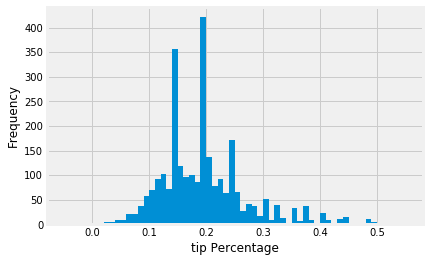

In [140]:
ax = yc200902_final_cut.tipPC.plot(kind="hist", bins=np.arange(-0.05, 
                                                                   0.55,
                                                                  0.01))
ax.set_xlabel("tip Percentage");

###### Fig 3

As Figure 2, but plotted with smaller bins of size 0.01%. The new binning reveals sharp peaks at 15%, 20%, and 25% of the trip fare: these are easily explained by automated tipping percentage options on credit card machines, as well as standarard tipping costumes.

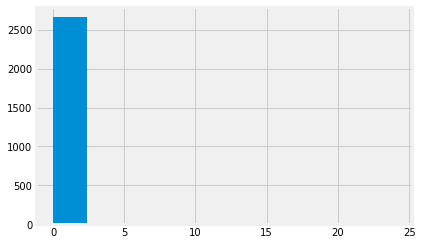

In [141]:
yc200902_final_cut.tripDuration.hist()

In [142]:
durationcut = (yc200902_final_cut.tripDuration>0) & (yc200902_final_cut.tripDuration<.5)

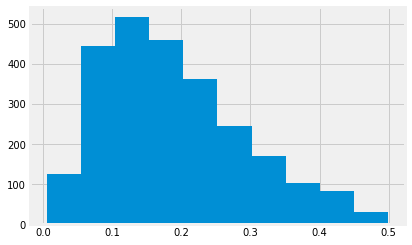

In [143]:
yc200902_final_cut[durationcut].tripDuration.hist()

In [144]:
yc200902_final_cut = yc200902_final_cut[durationcut]

##### Statistical tests to assess if the distribution is Gaussian
To assess if the distribution is in fact consistent with a Gaussian (however unlikely that is in the light of the structure of the distribution which was revealed by smaller than default binning) we set a significance threshold of 0.05 and we test the standardized distribution against a standard normal distribution with a KS  and an Anderson Darling test.

#### KS test: non parametric, sensitive to the core of the distribution

In [145]:
# statistical significance threshold
alpha = 0.05

In [146]:
ksTips = sp.stats.kstest((yc200902_final_cut.tipPC - 
                yc200902_final_cut.tipPC.mean())  / 
                         yc200902_final_cut.tipPC.std(), "norm")
verb = "does not " if ksTips[1] < alpha else "does "
print ("The distribution of tips " + verb + "follow a normal distribution (p < 0.05) " + 
      "according to the KS test")

The distribution of tips does not follow a normal distribution (p < 0.05) according to the KS test


#### AD test, parametric (light assumptions on Gaussianity), more power away from center than KS

In [147]:
adTips = sp.stats.anderson((yc200902_final_cut.tipPC - 
                yc200902_final_cut.tipPC.mean())  / 
                    yc200902_final_cut.tipPC.std(), "norm")
verb = "does not " if adTips[0] > adTips[1][adTips[2] == alpha * 100] else "does "
print ("The distribution of tips " + verb + "follow a normal distribution (p < 0.05) " + 
      "according to the AD test")


The distribution of tips does not follow a normal distribution (p < 0.05) according to the AD test


In [148]:
sp.stats.pearsonr(yc200902_final_cut.tripDuration, yc200902_final_cut.tipPC * yc200902_final_cut.Fare_Amt)

(0.4730532490009363, 5.6242229867786514e-142)

In [149]:
sp.stats.pearsonr(yc200902_final_cut.tripDuration, yc200902_final_cut.tipPC)

(-0.27663655378896496, 6.7054776257267975e-46)

In [150]:
sp.stats.pearsonr(yc200902_final_cut.Fare_Amt, yc200902_final_cut.tipPC * yc200902_final_cut.Fare_Amt)

(0.7602038914070466, 0.0)

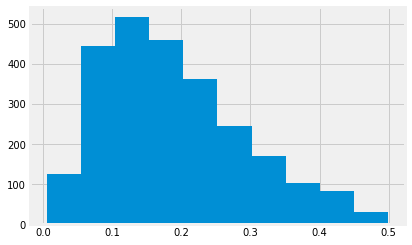

In [151]:
yc200902_final_cut.tripDuration.hist()

In [152]:
sp.stats.pearsonr(yc200902_final_cut.tripDuration, yc200902_final_cut.tipPC)


(-0.27663655378896496, 6.7054776257267975e-46)

In [153]:
sp.stats.pearsonr(yc200902_final_cut.tipPC, yc200902_final_cut.incomeDep), \
sp.stats.pearsonr(yc200902_final_cut.tipPC, yc200902_final_cut.incomeDes)


((-0.02116652291589819, 0.2859792030983739),
 (0.015357567351500219, 0.43886051060097053))

# 8. Modeling to assess colinearity of Fare and trip distance
## Fit a line to taxi fare vs trip duration and to taxi fare vs trip distance to decide which variable between duration and distance *contains more information when used in a model in conjunction with the fare*

##### assessing colinearity of fare and trip duration

In [154]:
# modeling fare with duration
tdmodel = smf.ols(formula='Fare_Amt ~ tripDuration', data=yc200902_final_cut).fit()
tdmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Fare_Amt   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     2872.
Date:                Wed, 21 Nov 2018   Prob (F-statistic):               0.00
Time:                        13:23:50   Log-Likelihood:                -7018.5
No. Observations:                2543   AIC:                         1.404e+04
Df Residuals:                    2541   BIC:                         1.405e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.2429      0.161     13.934      0.000       1.927       2.559
tripDuration    39.6577      0.740     53.589      0.000      38.207      41.109
==============================================================================
Omnibus:                     2861.873   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           262826.363
Skew:                           5.738   Prob(JB):                         0.00
Kurtosis:                      51.464   Cond. No.                         10.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Trip duration model has very low predictive power on fare. However the distribution of trip duration has not been evaluated yet

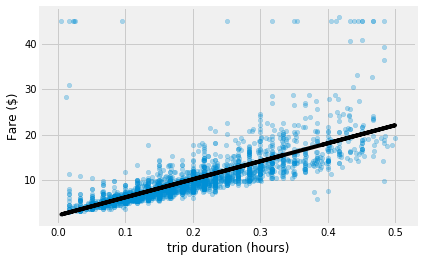

In [155]:
ax = yc200902_final_cut.plot.scatter(y="Fare_Amt", x="tripDuration", alpha=0.3)
ax.plot(yc200902_final_cut.tripDuration, tdmodel.fittedvalues, 'k')
ax.set_ylabel("Fare ($)")
ax.set_xlabel("trip duration (hours)");

###### Fig 4
Scatter plot of trip fare against trip duration for February rides with non-zero tip and tip < 50% of Fare (subsampled 1 out of 1000). Also plotted (black line) is a linear fit of trip duration to fare. This figure reveals that the low pedictive power of a model of trip fare from trip duration (Rsquares = 0.02 or 2% of the variance in fare explained by duration) is due to the presence of extreme values in the distribution of trip durations. The values are split in roughly two groups, one within 5 hours, and one with duration close to 24 hours. The latter group is due to trips that cross the date line incorrectly logged or processed to derive trip duration. 

#### removing upper 2.5% (mean + 2 stdev) and <0 rides by duration

In [156]:
yc200902_final_cut.tripDuration.describe()

count    2543.000000
mean        0.191855
std         0.102499
min         0.005278
25%         0.116667
50%         0.170278
75%         0.250278
max         0.499444
Name: tripDuration, dtype: float64

In [191]:
# there are no trip durations < 0 with this cut on tips, 
# but in case there were i leave that cut in
upperlim = yc200902_final_cut.tripDuration.mean() +\
    yc200902_final_cut.tripDuration.std() * 2

durationcut = (yc200902_final_cut[tipcut].tripDuration > 0) & (
    yc200902_final_cut[tipcut].tripDuration < upperlim)

yc200902_final_cut = yc200902_final[tipcut][durationcut]

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [192]:
print ("the size of the dataset after the cuts on duration are applied is " + 
       "{:d}, a fraction of {:.2f} of all registered rides".format(
    yc200902_final[tipcut][durationcut].shape[0], 
    yc200902_final[tipcut][durationcut].shape[0] * 1.0 / yc200902_short.shape[0]))

the size of the dataset after the cuts on duration are applied is 2650, a fraction of 0.20 of all registered rides


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Fare_Amt   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     1968.
Date:                Wed, 21 Nov 2018   Prob (F-statistic):          6.03e-322
Time:                        13:26:46   Log-Likelihood:                -8237.3
No. Observations:                2650   AIC:                         1.648e+04
Df Residuals:                    2648   BIC:                         1.649e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.4338      0.175     25.301      0.000       4.090       4.777
tripDuration    29.4976      0.665     44.367      0.000      28.194      30.801
==============================================================================
Omnibus:                     2014.358   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1927101.370
Skew:                          -2.243   Prob(JB):                         0.00
Kurtosis:                     135.034   Cond. No.                         6.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

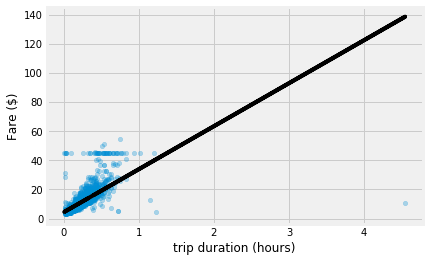

In [193]:
# trip duration model
tdmodel = smf.ols(formula='Fare_Amt ~ tripDuration', data=yc200902_final_cut).fit()
ax = yc200902_final_cut.plot.scatter(y="Fare_Amt", x="tripDuration", alpha=0.3)
ax.plot(yc200902_final_cut.tripDuration, tdmodel.fittedvalues, 'k')
ax.set_ylabel("Fare ($)")
ax.set_xlabel("trip duration (hours)");
tdmodel.summary()

###### Fig 5
As Figure 4 with outliers removed: rides shorter than 0 hours and longer than the 97.5%ile of the distribution. The fit significantly improved, with Rsquares = 0.4 or 40% of the variance in fare explained by duration. More outliers are observable in this plot: a single trip with duration >5 hours and several trips with fare exactly $45, the fixed fare from JFK. These can be considered outliers for the purpose of this analysis and will be removed in the next step.

#### cutting trip duration at 2 hours and removing fix fare

In [194]:
# cuts
durationcut = (yc200902_final.tripDuration > 0) & \
               (yc200902_final.tripDuration < 2) & \
               (~(yc200902_final.Fare_Amt == 45.0))
yc200902_final_cut = yc200902_final[tipcut][durationcut]

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Fare_Amt   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     5262.
Date:                Wed, 21 Nov 2018   Prob (F-statistic):               0.00
Time:                        13:26:49   Log-Likelihood:                -6671.8
No. Observations:                2601   AIC:                         1.335e+04
Df Residuals:                    2599   BIC:                         1.336e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.6654      0.119     22.465      0.000       2.433       2.898
tripDuration    36.1378      0.498     72.540      0.000      35.161      37.115
==============================================================================
Omnibus:                     1101.808   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           141662.821
Skew:                           0.974   Prob(JB):                         0.00
Kurtosis:                      39.102   Cond. No.                         8.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

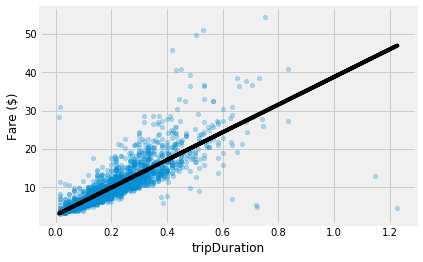

In [195]:
# redo duration model
tdmodel = smf.ols(formula='Fare_Amt ~ tripDuration', data=yc200902_final_cut).fit()
ax = yc200902_final_cut.plot.scatter(y="Fare_Amt", x="tripDuration",
                                    alpha=0.3)
ax.set_ylabel("Fare ($)")
ax.plot(yc200902_final_cut.tripDuration, tdmodel.fittedvalues, 'k')
tdmodel.summary()

###### Fig 6
As Figure 4 with outliers removed: rides shorter than 0 hours and longer than 2 hours and rides with fixed $45 fare. With these cuts trip duration predicts nearly 70% of the variance in the distribution. 

In [196]:
print ("the size of the dataset after the cuts on duration are applied is " + 
       "{:d}, a fraction of {:.2f} of all registered rides".format(
    yc200902_final_cut.shape[0], 
    yc200902_final_cut.shape[0] * 1.0 / yc200902_short.shape[0]))

the size of the dataset after the cuts on duration are applied is 2601, a fraction of 0.19 of all registered rides


In [197]:
# modeling fare and distance, using the original dataset
ddmodel = smf.ols(formula='Fare_Amt ~ Trip_Distance', 
                  data=yc200902_final[tipcut]).fit()
ddmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Fare_Amt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                 1.408e+04
Date:                Wed, 21 Nov 2018   Prob (F-statistic):               0.00
Time:                        13:26:50   Log-Likelihood:                -6646.9
No. Observations:                2684   AIC:                         1.330e+04
Df Residuals:                    2682   BIC:                         1.331e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.0625      0.078     51.802      0.000       3.909       4.216
Trip_Distance     2.2189      0.019    118.656      0.000       2.182       2.256
==============================================================================
Omnibus:                     4279.807   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2179020.412
Skew:                          10.254   Prob(JB):                         0.00
Kurtosis:                     141.072   Cond. No.                         6.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

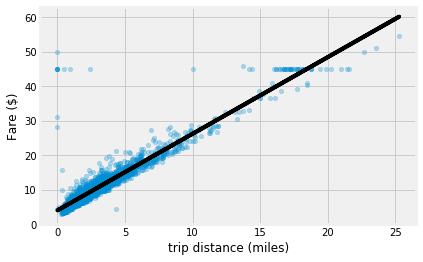

In [198]:
ax = yc200902_final[tipcut].plot.scatter(y="Fare_Amt", x="Trip_Distance", alpha=0.3)
ax.plot(yc200902_final[tipcut]["Trip_Distance"], ddmodel.fittedvalues, 'k')
ax.set_ylabel("Fare ($)")
ax.set_xlabel("trip distance (miles)");

###### Fig 7
Scatter plot of trip Fare against trip distance for February rides with non-zero tip and tip < 50% of Fare. Also plotted (black line) is a linear fit of trip distance to fare. The predictive power of distance is much higher than the predictive power of duration for fare: with the dataset where only tip outliers were removed the Rsquared is already over 80%. Nonetheless, some outliers are visible, particularly the same $45 fix fares that were seen in Figures 4 and 5.

# 9. Improve the fit by removing ''suspected'' outliers and *quantify* the improvement


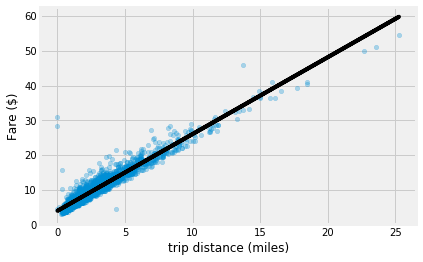

In [199]:
ddmodel = smf.ols(formula='Fare_Amt ~ Trip_Distance', data=yc200902_final_cut).fit()
ddmodel.summary()
ax = yc200902_final_cut.plot.scatter(y="Fare_Amt", x="Trip_Distance",
                                    alpha = 0.3)
ax.plot(yc200902_final_cut["Trip_Distance"], ddmodel.fittedvalues, 'k')
ax.set_ylabel("Fare ($)")
ax.set_xlabel("trip distance (miles)");

###### Fig 8
As Figure 7 with outliers removed: rides shorter than 0 hours and longer than 2 hours, and rides with fixed fare. A few trips appear to have negative distance and should be removed.  

In [200]:
print ("number of trips with negative distance %d"%(
        yc200902_final_cut["Trip_Distance"]<=0).sum())

number of trips with negative distance 3


#### removing negative distance trips

In [201]:
# cut on distance duration fare and tips
durationdistancecut = (yc200902_final.tripDuration > 0) & \
               (yc200902_final.tripDuration < 2) & \
    (yc200902_final["Trip_Distance"] > 0) & \
    (~(yc200902_final.Fare_Amt == 45.0))
yc200902_final_cut = yc200902_final[tipcut][durationdistancecut]

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Fare_Amt   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                 3.754e+04
Date:                Wed, 21 Nov 2018   Prob (F-statistic):               0.00
Time:                        13:26:54   Log-Likelihood:                -4532.7
No. Observations:                2598   AIC:                             9069.
Df Residuals:                    2596   BIC:                             9081.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.8784      0.042     93.027      0.000       3.797       3.960
Trip_Distance     2.2199      0.011    193.756      0.000       2.197       2.242
==============================================================================
Omnibus:                      930.516   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6561.040
Skew:                           1.515   Prob(JB):                         0.00
Kurtosis:                      10.171   Cond. No.                         5.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

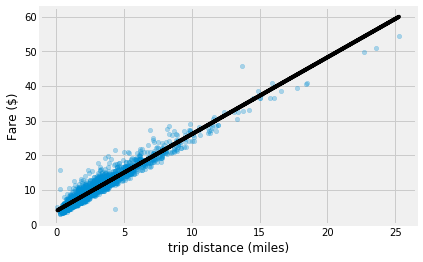

In [202]:
#redo distance model
ddmodel = smf.ols(formula='Fare_Amt ~ Trip_Distance', data=yc200902_final_cut).fit()
ax = yc200902_final_cut.plot.scatter(y="Fare_Amt", x="Trip_Distance",
                                    alpha = 0.3)
ax.plot(yc200902_final_cut["Trip_Distance"], ddmodel.fittedvalues, 'k')
ax.set_ylabel("Fare ($)")
ax.set_xlabel("trip distance (miles)");
ddmodel.summary()

###### Fig 9
As Figure 8 with outliers removed: all rides shorter than 0 hours and longer than 2 hours, rides with fixed fare at $45 and rides with negative distance. The predictive power of this model is excellent, with 94% of the variance on fare conveyed by distance.

In [203]:
print ("the size of the dataset after the cuts on duration are applied is " + 
       "{:d}, a fraction of {:.2f} of all registered rides".format(
    yc200902_final_cut.shape[0], 
    yc200902_final_cut.shape[0] * 1.0 / yc200902_short.shape[0]))

the size of the dataset after the cuts on duration are applied is 2598, a fraction of 0.19 of all registered rides


#### Which variable should be used with fare to model tips? 
Due to the high collinearity of fare and distance, these two variables should not be used as predictors together in a model. Therefore in the following models of tip with fare we will use duration

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Fare_Amt   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     5624.
Date:                Wed, 21 Nov 2018   Prob (F-statistic):               0.00
Time:                        13:26:55   Log-Likelihood:                -6592.6
No. Observations:                2598   AIC:                         1.319e+04
Df Residuals:                    2596   BIC:                         1.320e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.5923      0.116     22.416      0.000       2.366       2.819
tripDuration    36.3943      0.485     74.992      0.000      35.443      37.346
==============================================================================
Omnibus:                      907.759   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           146107.842
Skew:                           0.509   Prob(JB):                         0.00
Kurtosis:                      39.725   Cond. No.                         8.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

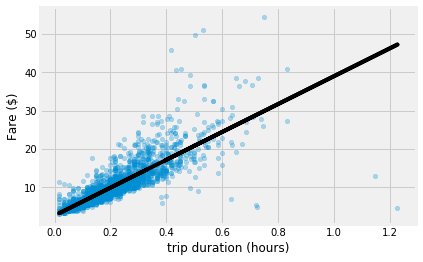

In [204]:
# assess trip duration model with final data cut
tdmodel = smf.ols(formula='Fare_Amt ~ tripDuration', data=yc200902_final_cut).fit()
ax = yc200902_final_cut.plot.scatter(y="Fare_Amt", x="tripDuration", 
                                    alpha=0.3)
ax.plot(yc200902_final_cut.tripDuration, tdmodel.fittedvalues, 'k')
ax.set_ylabel("Fare ($)")
ax.set_xlabel("trip duration (hours)")
tdmodel.summary()

###### Fig 10
As figure 7 with outliers removed: all rides shorter than 0 hours and longer than 2 hours, and rides with fixed fare at $45 and, in addition, rides with negative distance. The predictive power of the model is quitgood, but some 30% of the variance remains unexplained.

# 10. Multivariate models that include income
## Create a multivariate liner model to predict the tip percentage as a function of trip fare and another variable, the one you chose in step 8. Create also a linear model to predict the tip percentage as a multivariate linear model with variables trip duration or distance and trip fare, and  also includes  income (by zipcode) at arrival and destination

##### modeling trip percentage with fare and trip duration

In [205]:
# fare and duration model
m_Fare_Dur = smf.ols(formula='tipPC ~ Fare_Amt + tripDuration', 
                   data=yc200902_final_cut).fit()
m_Fare_Dur .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tipPC   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     87.39
Date:                Wed, 21 Nov 2018   Prob (F-statistic):           1.87e-37
Time:                        13:26:56   Log-Likelihood:                 3060.0
No. Observations:                2598   AIC:                            -6114.
Df Residuals:                    2595   BIC:                            -6096.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2333      0.003     75.817      0.000       0.227       0.239
Fare_Amt        -0.0019      0.000     -3.973      0.000      -0.003      -0.001
tripDuration    -0.0799      0.021     -3.799      0.000      -0.121      -0.039
==============================================================================
Omnibus:                      358.044   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              559.158
Skew:                           0.957   Prob(JB):                    3.81e-122
Kurtosis:                       4.224   Cond. No.                         164.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### the model has low predicive power with less than 10% variance explained: Rqueared = 0.062

##### modeling trip percentage with fare and trip duration and income at both destination and departure

In [206]:
# fare duration and both incomes model
m_Fare_Dur_IncDes_IncDep = smf.ols(formula=
                'tipPC ~ Fare_Amt + tripDuration + incomeDes + incomeDep', 
                   data=yc200902_final_cut).fit()
m_Fare_Dur_IncDes_IncDep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tipPC   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     45.64
Date:                Wed, 21 Nov 2018   Prob (F-statistic):           4.21e-37
Time:                        13:26:56   Log-Likelihood:                 3063.7
No. Observations:                2598   AIC:                            -6117.
Df Residuals:                    2593   BIC:                            -6088.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2459      0.006     43.837      0.000       0.235       0.257
Fare_Amt        -0.0022      0.000     -4.444      0.000      -0.003      -0.001
tripDuration    -0.0762      0.021     -3.619      0.000      -0.118      -0.035
incomeDes    -4.837e-05   2.18e-05     -2.217      0.027   -9.12e-05   -5.58e-06
incomeDep    -3.044e-05   2.23e-05     -1.367      0.172   -7.41e-05    1.32e-05
==============================================================================
Omnibus:                      357.883   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              559.827
Skew:                           0.956   Prob(JB):                    2.72e-122
Kurtosis:                       4.231   Cond. No.                     2.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### the predictive power of a model including fare, duration, and income at departure and destination is slightly higher, Rsquared = 0.065  compared to 0.062 of only fare and duration. This improvement is slight, and may not justify the added model complexity. To test if the model complexity is justified by the data, since these models are nested, a likelihood ratio test can be used.

# 11. Formal comparison of models and models with single income
## Compare the two models in step 10 *formally*. Which is a better model? Finally,  create two mode models,  one with duration/distance,  fare and income at departure, one with duration/distance,  fare and income at destination. Which is better? Why? `

##### Comparing model with and without income

In [207]:
# LR vetting function
def printLRresult(lr, alpha=0.05):
    '''function to print the result of a LR test in terms or NHST
    Arguments:
    lr: the likelihood ratio result from statsmodels compare_lr_test()
    alpha (optional): the significance threshold. Default alpha = 0.05'''

    rejected = False
    verb = "cannot "
    if lr[1] < alpha :
        rejected = True
        verb = "CAN "

    print ("The null hypothesis that the least complex model is better " + verb + 
           "be rejected (p<{:.2f})".format(alpha))
    return rejected
        

In [208]:
# compare model with fare and duration with model with fare duration and both income
lr1 = m_Fare_Dur_IncDes_IncDep.compare_lr_test(m_Fare_Dur)

if printLRresult(lr1):
    print ("The model including both income at destination and departure is better")
else:
    print ("Likelihood Ration p-value {:.2f}".format(lr1[1]))

The null hypothesis that the least complex model is better CAN be rejected (p<0.05)
The model including both income at destination and departure is better


##### Creating models with a single income predictor: destination or departure

#### Including only income at destination

In [209]:
m_Fare_Dur_IncDes = smf.ols(formula='tipPC ~ Fare_Amt + tripDuration + incomeDes', 
                     data=yc200902_final_cut).fit()
lr2 = m_Fare_Dur_IncDes_IncDep.compare_lr_test(m_Fare_Dur_IncDes)
if printLRresult(lr2):
    print ("The model including both incomes is " + 
           "better than the model with destination income")
else:
    print ("The model with destination income alone is better than the model " + 
           "including both incomes\n" + 
           "Likelihood Ration p-value {:.2f}".format(lr2[1]))    

The null hypothesis that the least complex model is better cannot be rejected (p<0.05)
The model with destination income alone is better than the model including both incomes
Likelihood Ration p-value 0.17


In [210]:
m_Fare_Dur_IncDes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tipPC   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     60.21
Date:                Wed, 21 Nov 2018   Prob (F-statistic):           1.25e-37
Time:                        13:26:58   Log-Likelihood:                 3062.7
No. Observations:                2598   AIC:                            -6117.
Df Residuals:                    2594   BIC:                            -6094.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2419      0.005     50.447      0.000       0.233       0.251
Fare_Amt        -0.0021      0.000     -4.355      0.000      -0.003      -0.001
tripDuration    -0.0781      0.021     -3.714      0.000      -0.119      -0.037
incomeDes    -5.123e-05   2.17e-05     -2.358      0.018   -9.38e-05   -8.63e-06
==============================================================================
Omnibus:                      356.671   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              557.131
Skew:                           0.954   Prob(JB):                    1.05e-121
Kurtosis:                       4.228   Cond. No.                     2.18e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### including only income at departure

In [211]:
m_Fare_Dur_IncDep = smf.ols(formula='tipPC ~ Fare_Amt + tripDuration + incomeDep', 
                     data=yc200902_final_cut).fit()
lr3 = m_Fare_Dur_IncDes_IncDep.compare_lr_test(m_Fare_Dur_IncDep)
if printLRresult(lr3):
    print ("The model including both incomes is " + 
           "better than the model with departure income")
else:
    print ("The model with departure income alone is better than the model" + 
           "including both incomes\n" + 
           "Likelihood Ration p-value {:.2f}".format(lr3[1]))    

The null hypothesis that the least complex model is better CAN be rejected (p<0.05)
The model including both incomes is better than the model with departure income


In [212]:
m_Fare_Dur_IncDep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tipPC   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     59.13
Date:                Wed, 21 Nov 2018   Prob (F-statistic):           5.69e-37
Time:                        13:26:59   Log-Likelihood:                 3061.2
No. Observations:                2598   AIC:                            -6114.
Df Residuals:                    2594   BIC:                            -6091.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2384      0.004     53.251      0.000       0.230       0.247
Fare_Amt        -0.0020      0.000     -4.104      0.000      -0.003      -0.001
tripDuration    -0.0777      0.021     -3.686      0.000      -0.119      -0.036
incomeDep    -3.517e-05   2.22e-05     -1.585      0.113   -7.87e-05    8.33e-06
==============================================================================
Omnibus:                      359.142   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              561.671
Skew:                           0.959   Prob(JB):                    1.08e-122
Kurtosis:                       4.228   Cond. No.                     2.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [213]:
lr4 = m_Fare_Dur_IncDes.compare_lr_test(m_Fare_Dur)
if printLRresult(lr4):
    print ("The model including destination incomes is " + 
           "better than the model with no income")

The null hypothesis that the least complex model is better CAN be rejected (p<0.05)
The model including destination incomes is better than the model with no income


# Conclusions:

We attempted to assess whether passenger's income is a good predictor of tip generosity. To do that we collected the tips as percentage of trip fare for yellow cab NYC rides in 02/2009, and postulated that the income of passengers could be represented by the mean income per person at the zipcode of either destination or departure. 

We begun our analysis with 13,380,122 observations (rides) and subsampled by a factor 1,000 to reduce the dataset to a manageable size for fast development. 

We identified the zipcode of departure and destination of each ride by spatial aggregation with a zipcode geographical dataset sugin the latitude and longitude of each pick-up and drop-off and associated each ride to income using IRS tax reports and number of individual by zipcode to generate a mean income feature. The spatial joint downsized our dataset by roughly 10%, leading to 11,981 observations at the beginning of our analysis.

The tips are dominated by $0 tips. These are likely a mix of missed tips and cash tips not recorded in order to not to have them taxed. This induces a bias in the analysis as the tipping behavior of costumers that pay cash and costumers that pay by credit card may be systematically different.

Outliers were dominating the sample and we removed outliers identified by value of the tip as percentage of fare, removing both excessive tips (>97.5 percentile) and tips of \$0 
(which were 77% of the sample). While some riders may not tip, we assumed that the $0 tips, which were the majority of the tips, were dominated by cash tips not registered to avoid taxation. This reduced the sample to only 20% of the original, or 2,684 rides. We then removed trips with negative duration, negative distance, duration that exceeded 2 hours and, finally, removed the fixed fare from the airport (\$45) leading to a final dataset of 2598 observations. 

We then generated linear models to evaluate the importance of income in predicting tips as a percentage of the ride fare.

The assumptions we made lead to the following concerns: 
   - income may vary significantly within a zipcode
   - spatial autocorrelation has not been taken into account
   - the income per person is calculated from the IRS tax reports for that zipcode residents with a rough estimate of the population as the sum of residents that file taxes, the joint returns, and the number of dependents. Likely this underestimates the number of residents slightly, thus overestimating the income per person, since tax exemped individuals are note included. Also a different birth rate, which is a quantity known to be different in defferent socioeconomic environments, would lead to a different significance of the income per person metric, and this may lead to systematic errors in our analysis.
   - there is no guarantee that either the zipcode at departure or destination is related to the rider's residence
   - including both incomes, even under the assumption that the one is the residence zipcode and thus the income of the rider is represented by either of those quantities, removes information about the trip "intention": likely tripping generosity is affected by disposition which is in turn affected by the purpose of the trip. 
   - in work trips the rider may have a radically different tipping attitude if they expect reimbursement. 

Further, in the analysis we model tip percentage based on fare and trip duration (tip distance was considered but it is too strongly collinear with fare). These quantities are not independent and this will induce issues in the model, and certainly issues with its interpretability.

The prediction of tip percentages from fare and duration is poor, and adding income improves it only slightly. We assessed wheather income actually has any predictive power by comparing the models without income and with, and with only one if the incomes between departure and destination. We assessed that in fact the models that include income are statistically significantly better, although only the income at destination has in fact any predictive power. 

#### The suggestion that only income at destination would be predictive of tips is troubling: it is possible that people are more likely to drive to their home than from their home, but there is no way to test this hypothesis with this data. Rather this should be interpreted as evidence that the departure and destination zipcodes are likely only loosely related to the riders' residence, leaving us with no evidence that including the income in this fashion would tap into information on the riders' socioeconomic status.  

#### It is possible for example that the purpose of the trip undertaken affects the generousity of the rider: riders that travel to leasure destinations (wicha may be in high income areas of etherogeneous nature, residential + ricreational + turistic, like Manhattan), may feel more compelled to tip as they are on a leasure journey.

##### Additional plots:
    

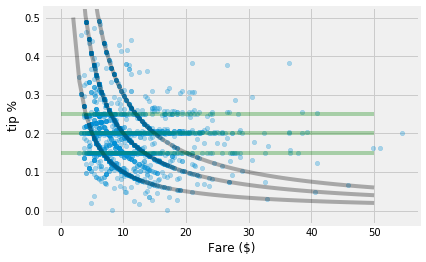

In [180]:
ax = yc200902_final_cut.plot.scatter(x="Fare_Amt", y="tipPC", alpha=0.3)
ax.set_xlabel("Fare ($)")
ax.set_ylabel("tip %")
ylim = ax.get_ylim()
ax.plot(np.linspace(2,50), 1.0 / np.linspace(2,50), 'k-', alpha=0.3)
ax.plot(np.linspace(2,50), 2.0 / np.linspace(2,50), 'k-', alpha=0.3)
ax.plot(np.linspace(2,50), 3.0 / np.linspace(2,50), 'k-', alpha=0.3)
ax.plot([0, 50], [0.15, 0.15], 'g-', alpha=0.3)
ax.plot([0, 50], [0.20, 0.20], 'g-', alpha=0.3)
ax.plot([0, 50], [0.25, 0.25], 'g-', alpha=0.3)
ax.set_ylim(ylim);

###### Fig 11
Tip percentage vs Fare: the scatter plot has a peculiar structure, with a concentration of tips at fixed percentages (as seen in Figure 3) but also distinct curves that are generated by tipping in fixed amounts: \$1, \$2, \$3 etc. 
The \$1, \$2, \$3 dollar tips are indicated by black lines and the 15%, 20%, and 25% tip lines in green.

In [181]:
durationdistancecut = ((yc200902_final.tripDuration > 0) & \
               (yc200902_final.tripDuration < 2) & \
    (yc200902_final["Trip_Distance"] > 0) & \
    (~(yc200902_final.Fare_Amt == 45.0)) &\
    (~((yc200902_final.tipPC / yc200902_final.Fare_Amt) == 0.2)) &\
    (~((yc200902_final.tipPC / yc200902_final.Fare_Amt) == 0.15)) &\
    (~((yc200902_final.tipPC / yc200902_final.Fare_Amt) == 0.25)) &\
    (~((yc200902_final.tipPC / yc200902_final.Fare_Amt).round(2) == 0.18)) &\
    (~((yc200902_final.tipPC > 0.7 / yc200902_final.Fare_Amt) & 
        (yc200902_final.tipPC < 1.3 / yc200902_final.Fare_Amt)) ) &\
    (~((yc200902_final.tipPC > 1.7 / yc200902_final.Fare_Amt) & 
        (yc200902_final.tipPC < 2.3 / yc200902_final.Fare_Amt)) ) &\
    (~((yc200902_final.tipPC > 2.7 / yc200902_final.Fare_Amt) & 
        (yc200902_final.tipPC < 3.3 / yc200902_final.Fare_Amt)) ) )

yc200902_final_allcuts = yc200902_final[tipcut][durationdistancecut]

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [182]:
print ("after attempting to remove tips close to the fix percentages and " + 
       "close to the net dollar amounts " + 
       "the data is still structured and now sparse: " + 
       "data size {:d} observations".format(yc200902_final_allcuts.shape[0]))

after attempting to remove tips close to the fix percentages and close to the net dollar amounts the data is still structured and now sparse: data size 778 observations


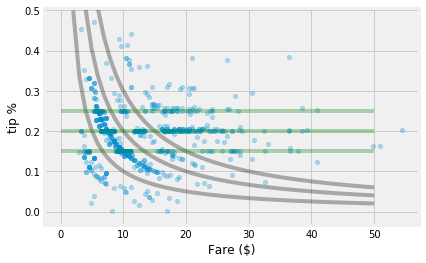

In [183]:
ax = yc200902_final_allcuts.plot.scatter(x="Fare_Amt", y="tipPC", alpha=0.3)
ax.set_xlabel("Fare ($)")
ax.set_ylabel("tip %")
ylim = ax.get_ylim()
ax.plot(np.linspace(2,50), 1.0 / np.linspace(2,50), 'k-', alpha=0.3)
ax.plot(np.linspace(2,50), 2.0 / np.linspace(2,50), 'k-', alpha=0.3)
ax.plot(np.linspace(2,50), 3.0 / np.linspace(2,50), 'k-', alpha=0.3)
ax.plot([0, 50], [0.15, 0.15], 'g-', alpha=0.3)
ax.plot([0, 50], [0.20, 0.20], 'g-', alpha=0.3)
ax.plot([0, 50], [0.25, 0.25], 'g-', alpha=0.3)
ax.set_ylim(ylim);

# Fig 12 
Tip percentage as function of fare after removing tips near fix percentages (15, 20 and 15) and net dollar ($1, 2, 3) amount.
The structured imposed by fixed percentage tips and net dollar tips may affect the prediction but removing this strucutre from the data is rather difficult.  After attempting to remove these specific tips we end up with a dataset that still has a peculiar structure and is now rather sparse.